In [1]:
import csv

import matplotlib.pylab as plt
from matplotlib.patches import Patch
from matplotlib import collections
from matplotlib import colors
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
index = ('ms', 0)

columns = {
    'RLA_acc_x':  63,
    'RLA_acc_y':  64,
    'RLA_acc_z':  65,
    'RLA_gyr_x':  66,
    'RLA_gyr_y':  67,
    'RLA_gyr_z':  68,
    'LLA_acc_x':  89,
    'LLA_acc_y':  90,
    'LLA_acc_z':  91,
    'LLA_gyr_x':  92,
    'LLA_gyr_y':  93,
    'LLA_gyr_z':  94,
    'LC': 243,
    'HL': 244,
    'ML': 249
}

categories = {
    'LC': {
        0: 'NULL',
        1: 'Stand',
        2: 'Walk',
        4: 'Sit',
        5: 'Lie'
    },
    'HL': {
        0:   'NULL',
        101: 'Relaxing',
        102: 'Coffee time',
        103: 'Early Morning',
        104: 'Cleanup',
        105: 'Sandwich time'
    },
    'ML': {
        0:      'NULL',
        406516: 'Open Door 1',
        406517: 'Open Door 2',
        404516: 'Close Door 1',
        404517: 'Close Door 2',
        406520: 'Open Fridge',
        404520: 'Close Fridge',
        406505: 'Open Dishwasher',
        404505: 'Close Dishwasher',
        406519: 'Open Drawer 1',
        404519: 'Close Drawer 1',
        406511: 'Open Drawer 2',
        404511: 'Close Drawer 2',
        406508: 'Open Drawer 3',
        404508: 'Close Drawer 3',
        408512: 'Clean Table',
        407521: 'Drink from Cup',
        405506: 'Toggle Switch',
    }
}

In [3]:
def dataset(path: str, columns):
    def read():
        with open(path, 'r', newline='') as file:
            reader = csv.reader(file, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
            for row in reader:
                yield row
    
    ds = tf.data.Dataset.from_generator(
        lambda: read(),
        output_types=tf.float32,
        output_shapes=(250)
    )
    
    return ds.map(lambda t: tf.gather(t, columns))

def dataframe(ds: tf.data.Dataset, index, columns, categories):
    df = pd.DataFrame(ds.as_numpy_iterator(), columns=[index] + columns).dropna()
    
    for k, v in categories.items():
        df[k] = df[k].astype('category')
        df[k].cat.categories = [v[int(cat)] for cat in df[k].cat.categories]
        
    return df.set_index(pd.to_timedelta(df[index], 'ms')).drop(columns=[index])

def mode(x):
    m = pd.Series.mode(x)
    return m.values[0] if not m.empty else 'NULL'

def to_minutes(index):
    return pd.to_numeric(index) / 60000000000

In [4]:
adl = dataframe(
    dataset('/mnt/dsets/OpportunityUCIDataset/dataset/S1-ADL1.dat', [index[1]] + list(columns.values())),
    index[0],
    list(columns.keys()),
    categories
)

In [5]:
adl_magnitude = adl.assign(
    RLA_acc=np.sqrt(np.power(adl['RLA_acc_x'], 2) + np.power(adl['RLA_acc_y'], 2) + np.power(adl['RLA_acc_z'], 2)),
    RLA_gyr=np.sqrt(np.power(adl['RLA_gyr_x'], 2) + np.power(adl['RLA_gyr_y'], 2) + np.power(adl['RLA_gyr_z'], 2)),
    LLA_acc=np.sqrt(np.power(adl['LLA_acc_x'], 2) + np.power(adl['LLA_acc_y'], 2) + np.power(adl['LLA_acc_z'], 2)),
    LLA_gyr=np.sqrt(np.power(adl['LLA_gyr_x'], 2) + np.power(adl['LLA_gyr_y'], 2) + np.power(adl['LLA_gyr_z'], 2))
)[['RLA_acc', 'RLA_gyr', 'LLA_acc', 'LLA_gyr', 'ML']]

In [6]:
adl_cat = adl[['LC', 'HL', 'ML']].resample('1s').agg({
    'LC': mode,
    'HL': mode,
    'ML': mode
})

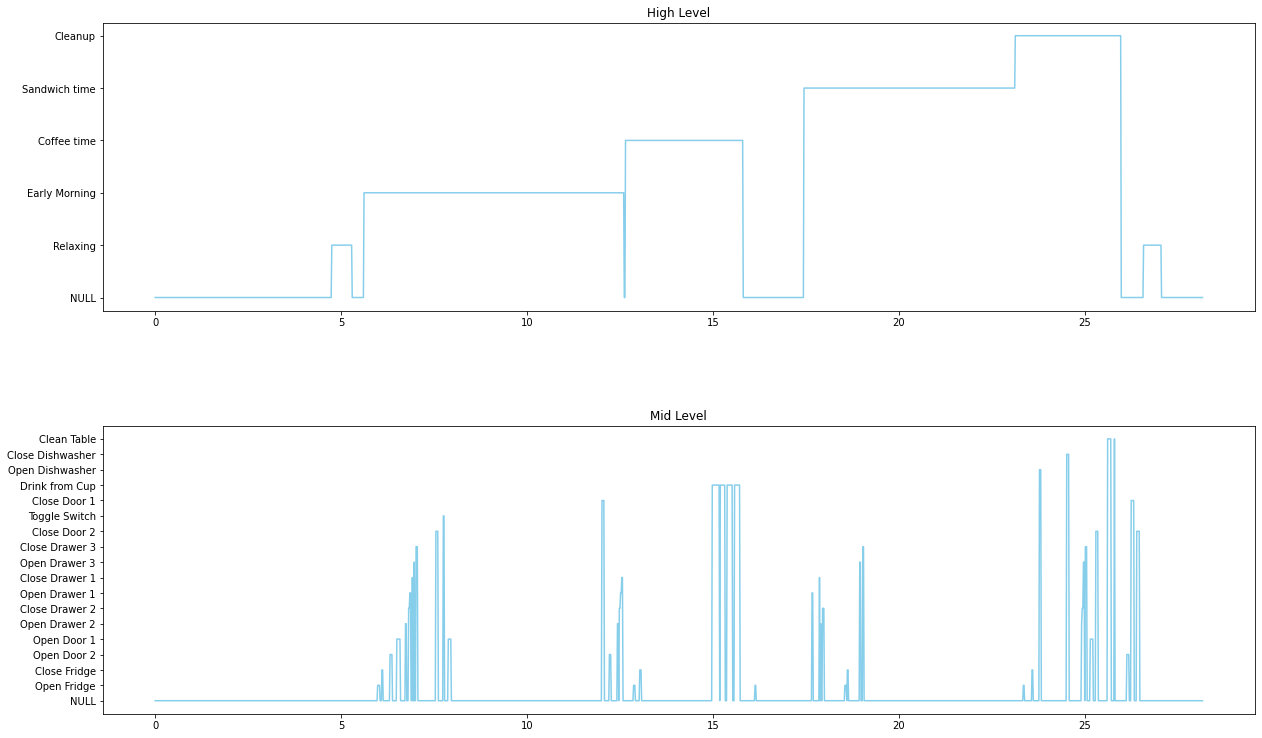

In [57]:
fig, axs = plt.subplots(2, 1, figsize=(20, 12))


axs[0].plot(to_minutes(adl_cat.index), adl_cat['HL'], color='skyblue')
axs[0].set_title('High Level')

axs[1].plot(to_minutes(adl_cat.index), adl_cat['ML'], color='skyblue')
axs[1].set_title('Mid Level')
    
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

fig.savefig('/home/Lando.Loeper/ocd-detection/adl_script.png')

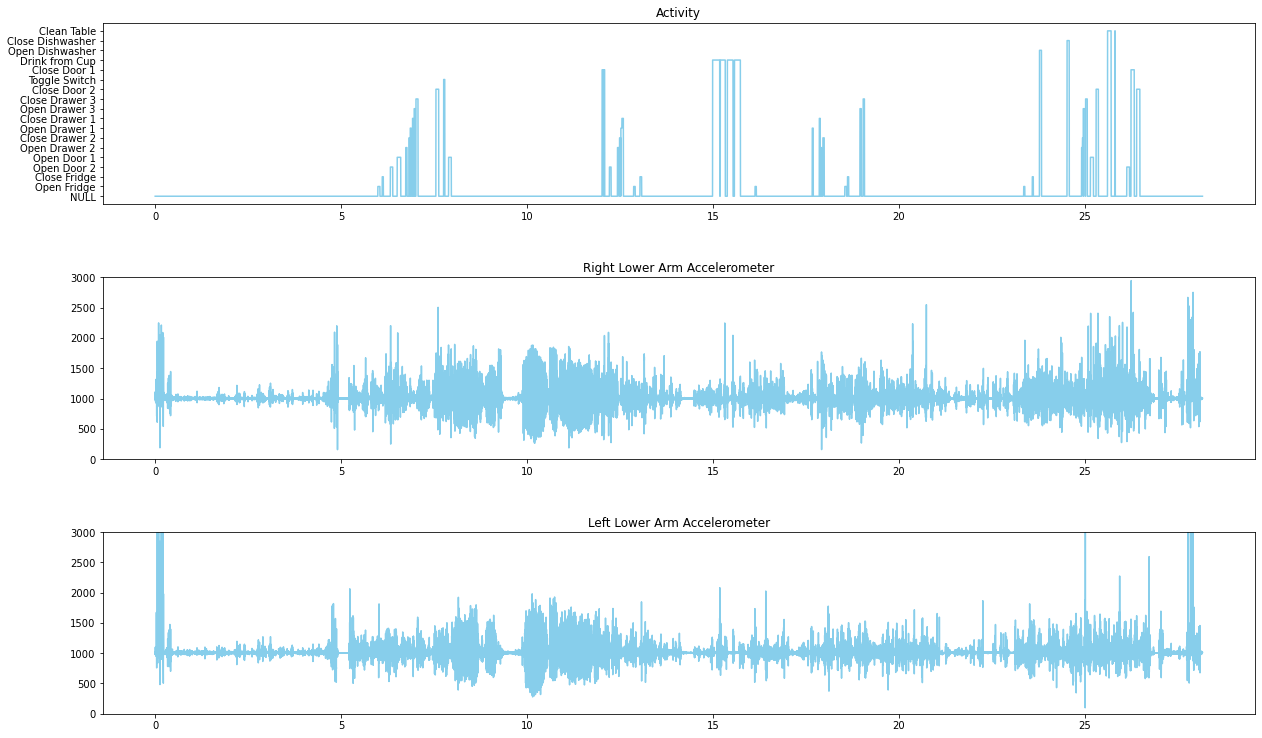

In [58]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12))

axs[0].plot(to_minutes(adl_magnitude.index), adl_magnitude['ML'], color='skyblue')
axs[0].set_title('Activity')

axs[1].plot(to_minutes(adl_magnitude.index), adl_magnitude['RLA_acc'], color='skyblue')
axs[1].set_title('Right Lower Arm Accelerometer')
axs[1].set_ylim(0, 3000)

axs[2].plot(to_minutes(adl_magnitude.index), adl_magnitude['LLA_acc'], color='skyblue')
axs[2].set_title('Left Lower Arm Accelerometer')
axs[2].set_ylim(0, 3000)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

fig.savefig('/home/Lando.Loeper/ocd-detection/adl_overview.png')

In [8]:
drill = dataframe(
    dataset('/mnt/dsets/OpportunityUCIDataset/dataset/S1-Drill.dat', [index[1]] + list(columns.values())),
    index[0],
    list(columns.keys()),
    categories
)

In [9]:
drill_magnitude = drill.assign(
    RLA_acc=np.sqrt(np.power(drill['RLA_acc_x'], 2) + np.power(drill['RLA_acc_y'], 2) + np.power(drill['RLA_acc_z'], 2)),
    RLA_gyr=np.sqrt(np.power(drill['RLA_gyr_x'], 2) + np.power(drill['RLA_gyr_y'], 2) + np.power(drill['RLA_gyr_z'], 2)),
    LLA_acc=np.sqrt(np.power(drill['LLA_acc_x'], 2) + np.power(drill['LLA_acc_y'], 2) + np.power(drill['LLA_acc_z'], 2)),
    LLA_gyr=np.sqrt(np.power(drill['LLA_gyr_x'], 2) + np.power(drill['LLA_gyr_y'], 2) + np.power(drill['LLA_gyr_z'], 2))
)[['RLA_acc', 'RLA_gyr', 'LLA_acc', 'LLA_gyr', 'ML']]

In [10]:
drill_cat = drill[['ML']].resample('1s').agg({ 'ML': mode })

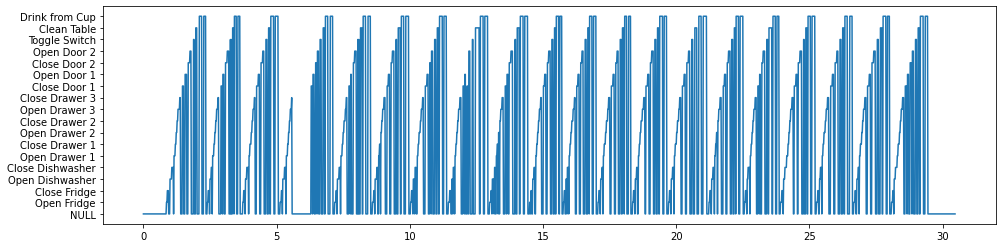

In [11]:
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(to_minutes(drill_cat.index), drill_cat['ML'])

plt.show()

In [12]:
adl_magnitude_fridge = adl_magnitude[(adl_magnitude['ML'] == 'Open Fridge') | (adl_magnitude['ML'] == 'Close Fridge')]
adl_magnitude_fridge_reset = adl_magnitude_fridge.reset_index(drop=True)

In [13]:
x = adl_magnitude_fridge_reset.index
labels=(adl_magnitude_fridge_reset['ML'] != 'Open Fridge').astype(np.int)

In [14]:
cmap = dict(enumerate(['orange', 'red']))
line_colors = labels.apply(cmap.get).to_numpy()

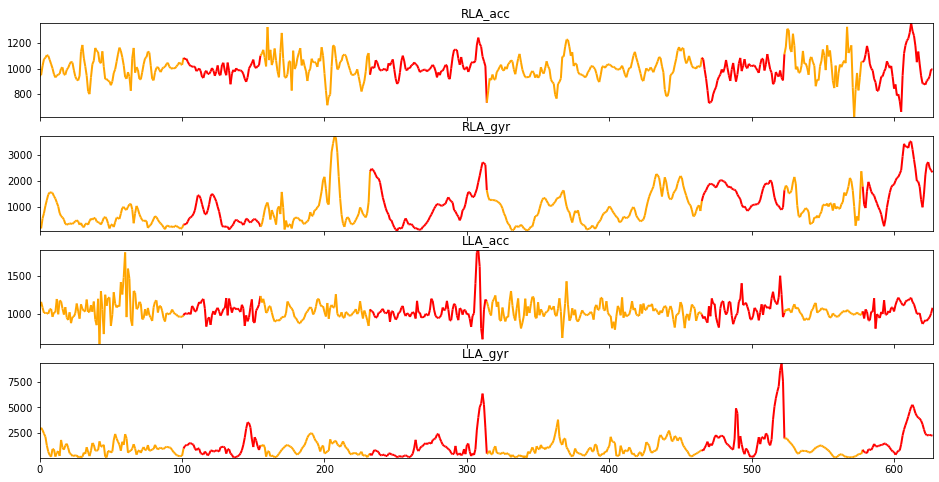

In [15]:
fig, axs = plt.subplots(4, 1, figsize=(16, 8), sharex=True)

for idx, c in enumerate(['RLA_acc', 'RLA_gyr', 'LLA_acc', 'LLA_gyr']):
    y = adl_magnitude_fridge_reset[c]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = collections.LineCollection(segments, linewidth=2, colors=line_colors)
    
    axs[idx].set_title(c)
    axs[idx].add_collection(lc)
    axs[idx].set_ylim(y.min(), y.max())
    
axs[0].set_xlim(x.min(), x.max())

plt.show()

In [16]:
drill_magnitude_fridge = drill_magnitude[(drill_magnitude['ML'] == 'Open Fridge') | (drill_magnitude['ML'] == 'Close Fridge')]
drill_magnitude_fridge_reset = drill_magnitude_fridge.reset_index(drop=True)

In [17]:
x = drill_magnitude_fridge_reset.index
labels=(drill_magnitude_fridge_reset['ML'] != 'Open Fridge').astype(np.int)

In [18]:
cmap = dict(enumerate(['orange', 'red']))
line_colors = labels.apply(cmap.get).to_numpy()

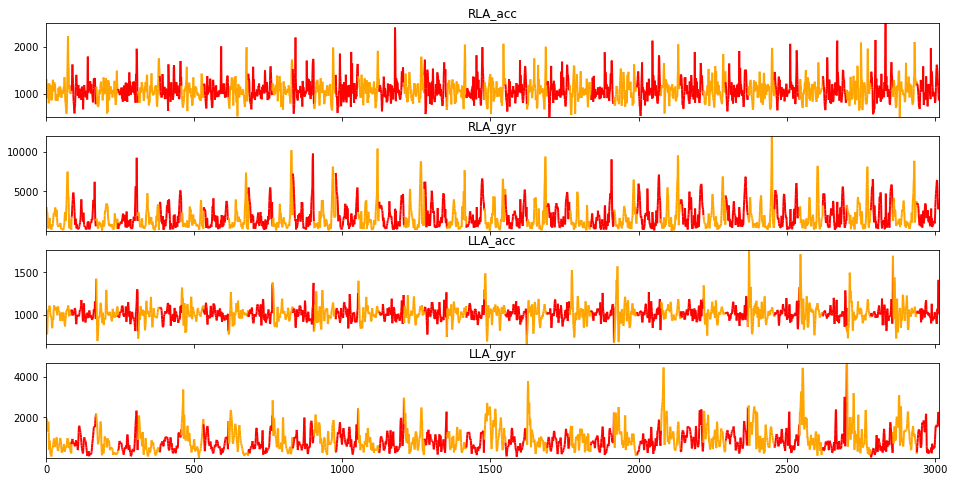

In [19]:
fig, axs = plt.subplots(4, 1, figsize=(16, 8), sharex=True)

for idx, c in enumerate(['RLA_acc', 'RLA_gyr', 'LLA_acc', 'LLA_gyr']):
    y = drill_magnitude_fridge_reset[c]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = collections.LineCollection(segments, linewidth=2, colors=line_colors)

    axs[idx].set_title(c)
    axs[idx].add_collection(lc)
    axs[idx].set_ylim(y.min(), y.max())
    
axs[0].set_xlim(x.min(), x.max())

plt.show()

In [20]:
# 5min 59s - 6min 3s / 6min 6s - 6min 9s
# 12min 51s - 12min 53s / 13min 2s - 13min 05s
# 16min 7s - 16min 10s / 
# 18min 32s - 18min 36s / 18min 37s - 18min 38s
# 23min 21s - 23min 24s / 23min 35s - 23min 37s

In [20]:
adl_magnitude_fridge_one = adl_magnitude.loc['5min 55s': '6min 15s'].copy()

In [59]:
x = to_minutes(adl_magnitude_fridge_one.index)

open_label = (adl_magnitude_fridge_one['ML'] == 'Open Fridge').astype(np.int)
close_label = (adl_magnitude_fridge_one['ML'] == 'Close Fridge').astype(np.int) * 2
labels = open_label + close_label

cmap = dict(enumerate(['skyblue', 'orange', 'red']))
line_colors = labels.apply(cmap.get).to_numpy()

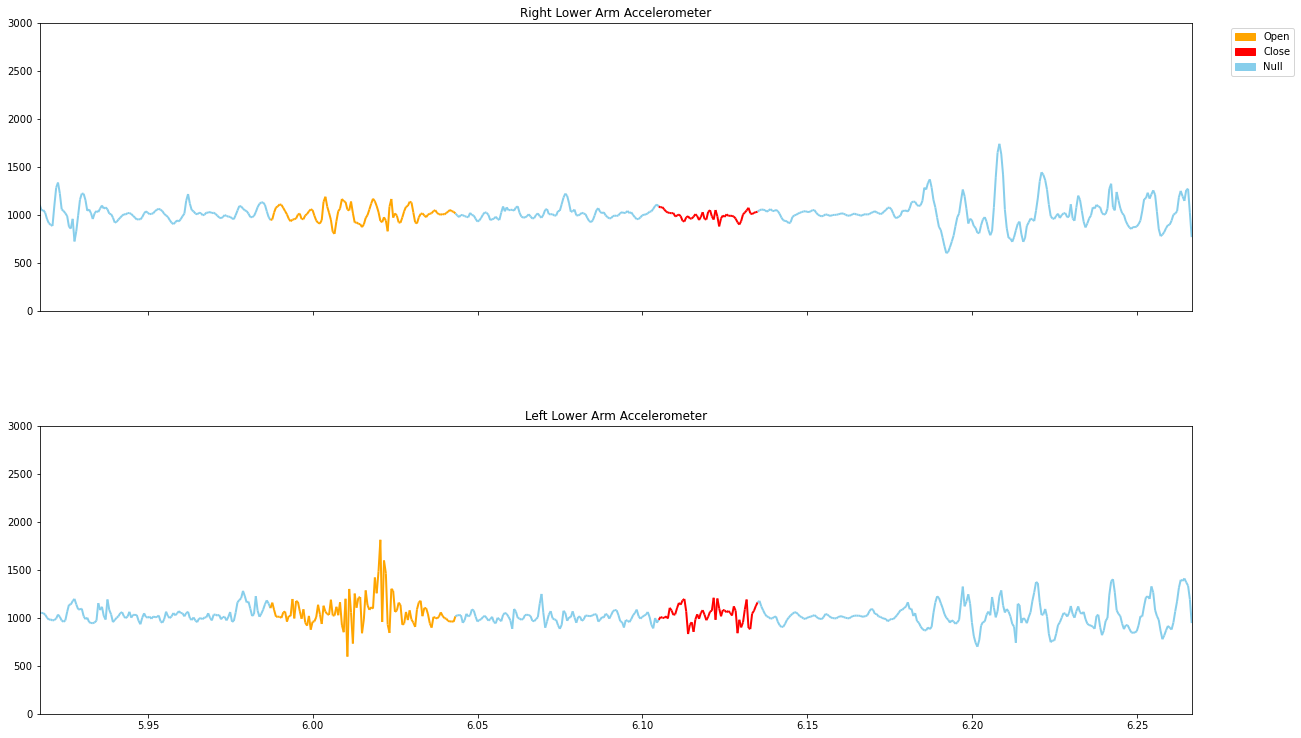

In [60]:
fig, axs = plt.subplots(2, 1, figsize=(20, 12), sharex=True, sharey=True)

y = adl_magnitude_fridge_one['RLA_acc']
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = collections.LineCollection(segments, linewidth=2, colors=line_colors)
axs[0].set_title('Right Lower Arm Accelerometer')
axs[0].add_collection(lc)
axs[0].set_ylim(0, 3000)
axs[0].set_xlim(x.min(), x.max())

y = adl_magnitude_fridge_one['LLA_acc']
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = collections.LineCollection(segments, linewidth=2, colors=line_colors)
axs[1].set_title('Left Lower Arm Accelerometer')
axs[1].add_collection(lc)
axs[1].set_ylim(0, 3000)
axs[1].set_xlim(x.min(), x.max())

open_patch = Patch(color='orange', label='Open')
close_patch = Patch(color='red', label='Close')
null_patch = Patch(color='skyblue', label='Null')
plt.legend(handles=[open_patch, close_patch, null_patch], bbox_to_anchor=(1.03, 2.4), loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

fig.savefig('/home/Lando.Loeper/ocd-detection/non_ocd.png')

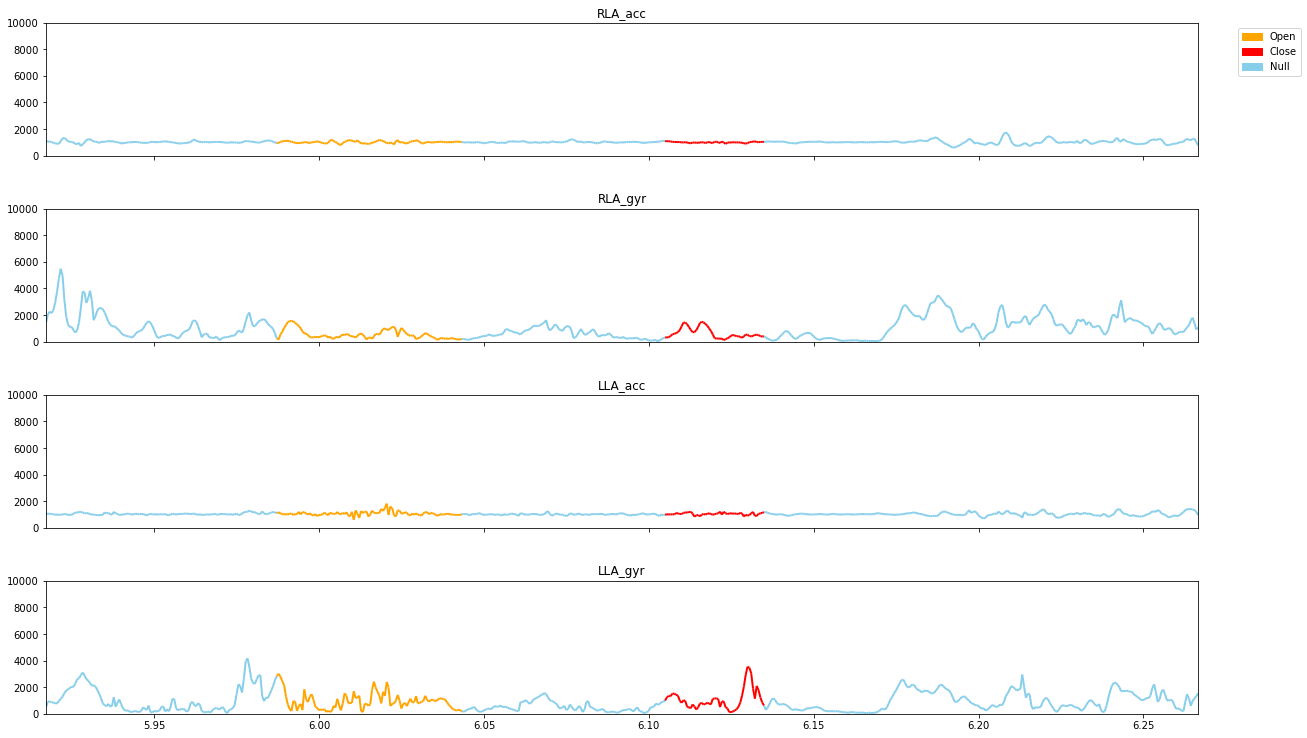

In [54]:
fig, axs = plt.subplots(4, 1, figsize=(20, 12), sharex=True, sharey=True)

for idx, c in enumerate(['RLA_acc', 'RLA_gyr', 'LLA_acc', 'LLA_gyr']):
    y = adl_magnitude_fridge_one[c]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = collections.LineCollection(segments, linewidth=2, colors=line_colors)

    axs[idx].set_title(c)
    axs[idx].add_collection(lc)
    
axs[0].set_ylim(0, 10000)
axs[0].set_xlim(x.min(), x.max())

open_patch = Patch(color='orange', label='Open')
close_patch = Patch(color='red', label='Close')
null_patch = Patch(color='skyblue', label='Null')
plt.legend(handles=[open_patch, close_patch, null_patch], bbox_to_anchor=(1.03, 5.2), loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

fig.savefig('/home/Lando.Loeper/ocd-detection/non_ocd_behaviour.png')

In [34]:
adl_magnitude_fridge_one_before = adl_magnitude_fridge_one.loc[:'6min 9s']
adl_magnitude_fridge_one_after = adl_magnitude_fridge_one.loc['6min 9s':]

In [35]:
# 51s - 54s / 54s - 57s
# 2min 23s / 2min 28s
# 3min 44s / 3min 48s

In [36]:
dmr_one_open = drill_magnitude[drill_magnitude['ML'] == 'Open Fridge'].loc['51s': '54s']
dmr_one_null = drill_magnitude[drill_magnitude['ML'] == 'NULL'].loc['53s': '55s']
dmr_one_close = drill_magnitude[drill_magnitude['ML'] == 'Close Fridge'].loc['54s': '57s']
dmr_one = pd.concat([dmr_one_open, dmr_one_null, dmr_one_close])
dmr_one.index = dmr_one.index - dmr_one.index[0] + adl_magnitude_fridge_one_before.index[-1] + pd.Timedelta('0.03s')

In [37]:
dmr_two_open = drill_magnitude[drill_magnitude['ML'] == 'Open Fridge'].loc['2min 23s': '2min 26s']
dmr_two_null = drill_magnitude[drill_magnitude['ML'] == 'NULL'].loc['2min 25s': '2min 27s']
dmr_two_close = drill_magnitude[drill_magnitude['ML'] == 'Close Fridge'].loc['2min 26s': '2min 28s']
dmr_two = pd.concat([dmr_two_open, dmr_two_null, dmr_two_close])
dmr_two.index = dmr_two.index - dmr_two.index[0] + dmr_one.index[-1] + pd.Timedelta('0.03s')

In [38]:
dmr_three_open = drill_magnitude[drill_magnitude['ML'] == 'Open Fridge'].loc['3min 44s': '3min 46s']
dmr_three_close = drill_magnitude[drill_magnitude['ML'] == 'Close Fridge'].loc['3min 46s': '3min 48s']
dmr_three = pd.concat([dmr_three_open, dmr_three_close])
dmr_three.index = dmr_three.index - dmr_three.index[0] + dmr_two.index[-1] + pd.Timedelta('0.03s')

In [39]:
dmr_merged = pd.concat([dmr_one, dmr_two, dmr_three])

In [40]:
adl_magnitude_fridge_one_after.index = adl_magnitude_fridge_one_after.index - adl_magnitude_fridge_one_after.index[0] + dmr_merged.index[-1] + pd.Timedelta('0.03s')

In [41]:
adl_magnitude_fridge_ocd = pd.concat([adl_magnitude_fridge_one_before, dmr_merged, adl_magnitude_fridge_one_after])

In [61]:
x = to_minutes(adl_magnitude_fridge_ocd.index)

open_label = (adl_magnitude_fridge_ocd['ML'] == 'Open Fridge').astype(np.int)
close_label = (adl_magnitude_fridge_ocd['ML'] == 'Close Fridge').astype(np.int) * 2
labels = open_label + close_label

cmap = dict(enumerate(['skyblue', 'orange', 'red']))
line_colors = labels.apply(cmap.get).to_numpy()

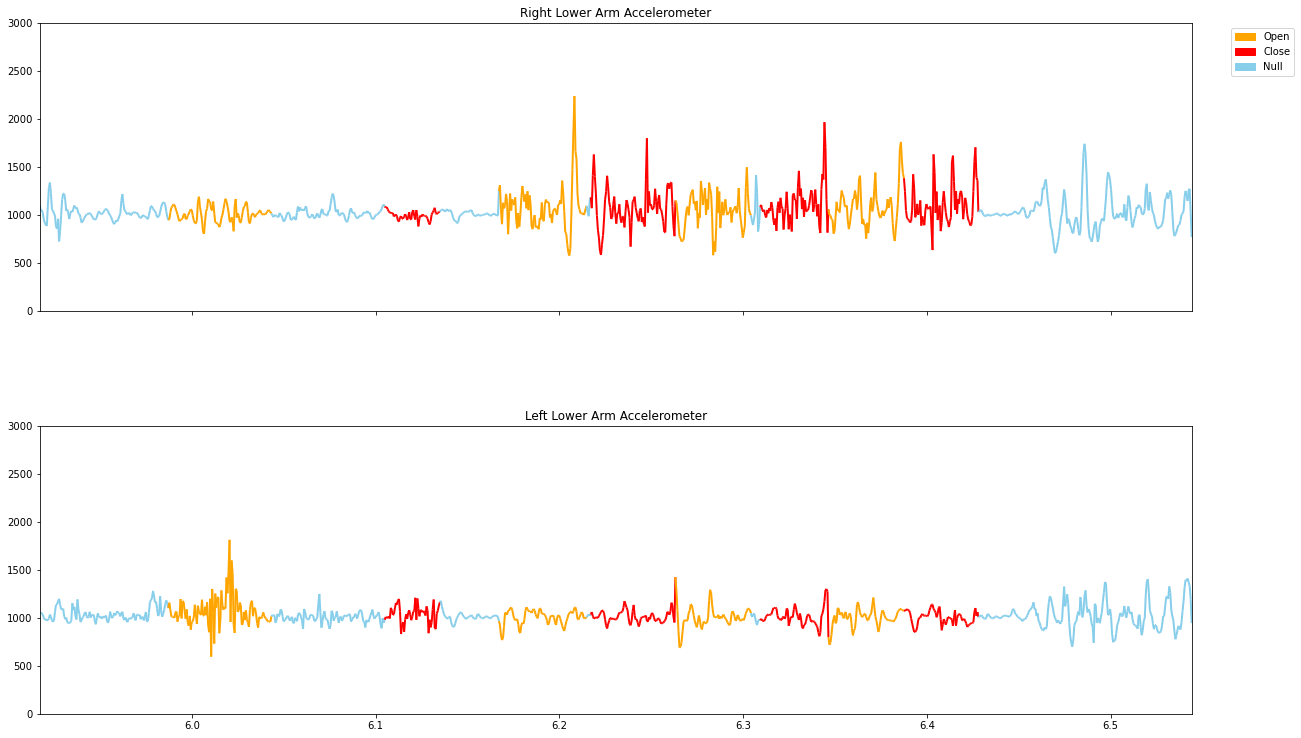

In [62]:
fig, axs = plt.subplots(2, 1, figsize=(20, 12), sharex=True, sharey=True)

y = adl_magnitude_fridge_ocd['RLA_acc']
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = collections.LineCollection(segments, linewidth=2, colors=line_colors)
axs[0].set_title('Right Lower Arm Accelerometer')
axs[0].add_collection(lc)
axs[0].set_ylim(0, 3000)
axs[0].set_xlim(x.min(), x.max())

y = adl_magnitude_fridge_ocd['LLA_acc']
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = collections.LineCollection(segments, linewidth=2, colors=line_colors)
axs[1].set_title('Left Lower Arm Accelerometer')
axs[1].add_collection(lc)
axs[1].set_ylim(0, 3000)
axs[1].set_xlim(x.min(), x.max())

open_patch = Patch(color='orange', label='Open')
close_patch = Patch(color='red', label='Close')
null_patch = Patch(color='skyblue', label='Null')
plt.legend(handles=[open_patch, close_patch, null_patch], bbox_to_anchor=(1.03, 2.4), loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

fig.savefig('/home/Lando.Loeper/ocd-detection/ocd_behaviour.png')